[View in Colaboratory](https://colab.research.google.com/github/Jane1118/music-genre-finder/blob/master/music_genre_CNNmodel_2580.ipynb)

# Modelling music genres with Convolutional Neural Networks

The previous notebook was mostly about **data processing**:
- Download the initial data,
- Reduce it,
- Make it more readable.

Here, we will be using the output of that previous notebook.

## Importing the data we need

Note: the Google Drive download **should work** no matter the Google account the user may choose for the authentication.

In [0]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [0]:
!pip install torchvision

    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 519.5MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59098000 @  0x7f5b11fad2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 2.0MB 2.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torchvision
from torchvision import models,transforms,datasets

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz

zip_id = '1n-sRLDAAZfdibGQXPYYo8v0s0rcDGJC6'
downloaded = drive.CreateFile({'id': zip_id})
downloaded.GetContentFile('zip_spectrogram.zip')

small_id = "1maJ4o_aHSy-ZLHUzOYuQ0QnRbS3rIciX"
downloaded = drive.CreateFile({'id': small_id})
downloaded.GetContentFile('small_tracks.csv')


tracks_id = "1me5bv76Fd9mFyJd25TSzOrl6SrcxsFFk"
downloaded = drive.CreateFile({'id': tracks_id})
downloaded.GetContentFile('tracks.csv')


#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

The step of unzipping the spectrograms, and then loading them to the memory, still takes pretty long (though much less so than the original one).

In [0]:
!unzip zip_spectrogram.zip

Archive:  zip_spectrogram.zip
   creating: spectrogram/
  inflating: spectrogram/109905.txt  
  inflating: spectrogram/126187.txt  
  inflating: spectrogram/122809.txt  
  inflating: spectrogram/116704.txt  
  inflating: spectrogram/003832.txt  
  inflating: spectrogram/127299.txt  
  inflating: spectrogram/152545.txt  
  inflating: spectrogram/004233.txt  
  inflating: spectrogram/108014.txt  
  inflating: spectrogram/031887.txt  
  inflating: spectrogram/063804.txt  
  inflating: spectrogram/042046.txt  
  inflating: spectrogram/145710.txt  
  inflating: spectrogram/043842.txt  
  inflating: spectrogram/114279.txt  
  inflating: spectrogram/006394.txt  
  inflating: spectrogram/004070.txt  
  inflating: spectrogram/092129.txt  
  inflating: spectrogram/092951.txt  
  inflating: spectrogram/048367.txt  
  inflating: spectrogram/006342.txt  
  inflating: spectrogram/081555.txt  
  inflating: spectrogram/143216.txt  
  inflating: spectrogram/044796.txt  
  inflating: spectrogram/126018.

In [0]:
len(os.listdir('spectrogram'))

1001

In [0]:
os.listdir('spectrogram')[0][:5]

'14129'

There is one extra file that appeared during the process and that we couldn't really get rid of before, so let's remove it now.

In [0]:
for file_name in os.listdir('spectrogram'):
  if file_name[-4:] != ".txt": # Remove the one file that does not have a .txt extension
    os.remove('spectrogram/' + file_name)

In [0]:
len(os.listdir('spectrogram'))

1000

Everything is in order: we can now import every text file in Numpy again.

In [0]:
small_tracks = pd.read_csv('small_tracks.csv')

In [0]:
small_tracks[:-5]

,track_id,genres,file_name
0,2,Hip-Hop,000/000002.mp3
1,5,Hip-Hop,000/000005.mp3
2,10,Pop,000/000010.mp3
3,140,Folk,000/000140.mp3
4,141,Folk,000/000141.mp3
5,148,Experimental,000/000148.mp3
6,182,Rock,000/000182.mp3
7,190,Folk,000/000190.mp3
8,193,Folk,000/000193.mp3
9,194,Folk,000/000194.mp3


In [0]:
small_tracks.loc[small_tracks['file_name'] == '000/000002.mp3']['genres']

0    Hip-Hop
Name: genres, dtype: object

In [0]:
file_name_test = os.listdir('spectrogram')[:5]
print(file_name_test)

['141290.txt', '014579.txt', '066075.txt', '064989.txt', '092556.txt']


In [0]:
test = file_name_test[0][:3]+'/'+file_name_test[0][:-4]+'.mp3'
testx = np.loadtxt('spectrogram/'+file_name_test[0])
testx = np.asarray(testx)
np.asarray(np.hsplit(testx,10)).shape

(10, 64, 258)

In [0]:
small_tracks.genres = small_tracks.genres.astype(str)
type(small_tracks.loc[small_tracks['file_name'] == test,'genres'].item())

str

In [0]:

type(small_tracks.loc[small_tracks['file_name'] == test].genres)

pandas.core.series.Series

#### nparray, i like array!

In [0]:
import time

start_time = time.time()

X = [] #list of 1000 arrays (64*2580) 
G = [] #list of 1000 labels in 8 classes
N = [] #list of 1000 names 

for file_name in os.listdir('spectrogram'):
  X.append(np.loadtxt('spectrogram/%s' % file_name)) 
  N.append(file_name[:-4])
  file_name_track = file_name[:3]+'/'+file_name[:-4]+'.mp3'
  G.append(small_tracks.loc[small_tracks['file_name'] == file_name_track,'genres'].item())

X = np.asarray(X)
G = np.asarray(G,dtype=str)
N = np.asarray(N)

print('Time lapsed: %f' % (time.time() - start_time))

Time lapsed: 154.265432


In [0]:
np.savez_compressed("mel_label.npz", X=X, G=G, N=N)

#### load the npz file


In [0]:
#load the npz file 
st = time.time()
data = np.load("mel_label.npz")
X = data["X"]
G = data["G"]
N = data["N"]
loading_time = time.time() - st
print("Loading takes %f seconds." % (loading_time))

BadZipFile: ignored

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f01c83f6470>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 210, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 201, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


In [0]:
# Use log transformation to preserve the order but shrink the range
X = np.log(X + 1)
X.shape

(1000, 64, 2580)

In [0]:
X.shape, G.shape

((1000, 64, 2580, 1), (1000,))

In [0]:
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# convert string type labels to vectors
genres = np.unique(G)
genres_dict = dict([[label, value] for value, label in enumerate(genres)])
G_numeric = np.asarray([genres_dict[label] for label in G])
G_vectorized = np_utils.to_categorical(G_numeric)

#### Split dataset into train, test, validation 7:2:1

In [0]:
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler


In [0]:
X[1].shape, G_vectorized[1].shape

((64, 2580), (8,))

In [0]:
num_train  =  len(X) 
#split 7:2:1 for train: valid: test
vali_size = 0.2
test_size = 0.1
indices = list(range(num_train))

In [0]:
validation_idx = np.random.choice(indices, size=int(vali_size*num_train), replace=False)
test_idx = np.random.choice(list(set(indices) - set(validation_idx)), size=int(test_size*num_train), replace=False)
train_idx = list(set(indices) - set(validation_idx)-set(test_idx))

In [0]:
#We use dataloader instead of this one 
training_X = X[train_idx]
validation_X = X[validation_idx]
testing_X = X[test_idx]

training_G = G_vectorized[train_idx]
validation_G = G_vectorized[validation_idx]
testing_G = G_vectorized[test_idx]

In [0]:
#combine label and sound to dataset
dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(G_vectorized.astype(np.int64))] for e in X]

In [0]:
dataset[0][0].shape

torch.Size([1, 64, 2580])

In [0]:
batch_size = 5

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, 
                batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, 
                batch_size=batch_size, sampler=validation_sampler)
test_loader = torch.utils.data.DataLoader(dataset, 
                batch_size=batch_size, sampler=test_sampler)


### Plot to check the dataset, reverse?


In [0]:
#default visualize size
default_figure_size = (6, 4)
sr = 22050 # sampling rate

In [0]:
#get some random training arrays 
dataiter = iter(train_loader)
images, labels = dataiter.next()

NameError: ignored

In [0]:
images[1].shape

NameError: ignored

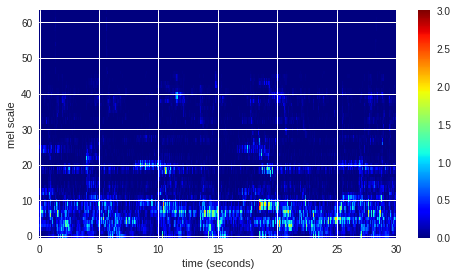

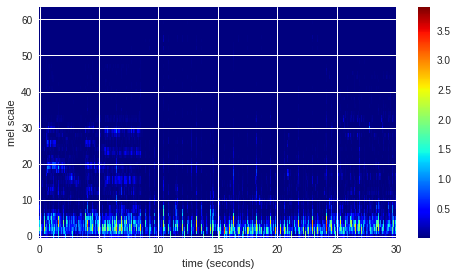

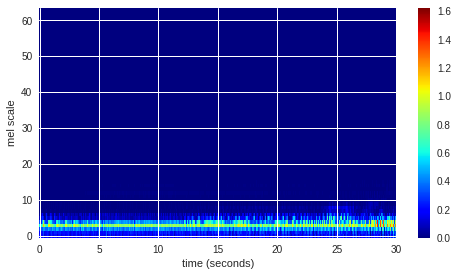

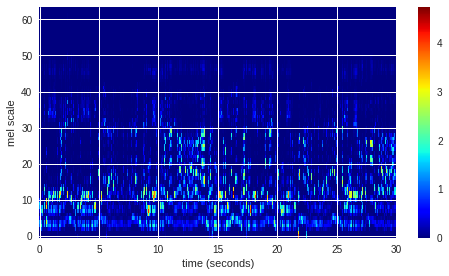

In [0]:
for i in range(4):
  plt.figure(figsize=(default_figure_size[0]+1, default_figure_size[1]))
  plt.imshow(images[i][0], origin="lower", aspect="auto", cmap="jet")
  plt.xticks(np.linspace(0, 2580, 7), np.arange(0, 31, 5))
  plt.xlabel("time (seconds)"); plt.ylabel("mel scale"); plt.colorbar(); plt.tight_layout()
  plt.show()

So, our dataloader works!

## Train the model
- what if not split to 10 parts 
- training: 700: validation: 200, test:100 
- X: (64,2580,1) Y: (8,)  one-hot array 

### Define a convolutional Neural Network 

In [0]:
# def baseline_model_64(num_genres=num_genres, input_shape=input_shape):
#     model = Sequential()
#     model.add(Conv2D(64, kernel_size=(3, 3),
#                      activation='relu', kernel_regularizer=regularizers.l2(0.01),
#                      input_shape=input_shape))
#     model.add(MaxPooling2D(pool_size=(2, 4)))
#     model.add(Conv2D(64, (3, 5), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPooling2D(pool_size=(2, 4)))
#     model.add(Dropout(0.2))
#     model.add(Flatten())
#     model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
#     model.add(Dropout(0.2))
#     model.add(Dense(num_genres, activation='softmax'))
#     model.compile(loss=keras.losses.categorical_crossentropy,
#                   optimizer=keras.optimizers.Adadelta(decay=1e-5),
#                   metrics=['accuracy'])
#     return(model)

In [0]:
#we use 1-channel image 
#no flattern, only drop once 
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #64 3*3 filters with stride 1 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
        #max pooling 2*4
        self.pool = nn.MaxPool2d(2, 4)
        #64 3*5 filters with stride 1
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,5), stride=1)
        #max pooling 2*4
        #dropout 0.2
        self.dropout = nn.Dropout(p=0.2, inplace=False)
        #fully connected layer 32 nerous to pervious ones 
        self.fc1 = nn.Linear(64 * 3 * 5, 32)
        #output layers 8 nerous fully connected 
        self.fc2 = nn.Linear(32, 8)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = self.dropout(x)
        #x = x.view(-1, 64 * 3 * 5)
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        #return x


In [0]:
net = Net()

In [0]:
x =images[1][0]
x = net(x)

RuntimeError: ignored

In [0]:
for k in net.parameters():
    print(k.size())

torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([64, 1, 3, 5])
torch.Size([64])
torch.Size([32, 960])
torch.Size([32])
torch.Size([8, 32])
torch.Size([8])


#### Define a loss function and optimizer 
-  Cross-Entropy Loss 
-  SGD opitimizer 

In [0]:
import torch.optim as optim 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001)

In [0]:
 enumerate(train_loader, 0)

#### Train the Network

In [0]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

ValueError: ignored